# 房间供暖场景探索：窗户、门、房间形状对温度分布的影响

**课程**: MATH3060/1 Group Project — Effective Control of Room Heating

**核心思路**: 所有物理场景（窗户、门、不同房间形状）都可以通过**同一个 PDE 求解器**来模拟，唯一的区别在于边界条件参数 $h(s)$ 的取值。

本 notebook 依次展示 6 个场景，从最简单的方形房间开始，逐步加入窗户、门、不同形状等物理特征。

---
## 1. 数学模型

在二维矩形域 $\Omega = [0, L_x] \times [0, L_y]$ 上求解热方程：

$$\frac{\partial T}{\partial t} = \alpha \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right) + S(x,y,t)$$

边界条件采用 **Robin BC**（第三类边界条件）：

$$\boxed{-\alpha \frac{\partial T}{\partial n} = h(s) \cdot (T - T_a)}$$

其中 $h(s) \geq 0$ 可以沿墙面变化。**所有物理场景的区别仅在于 $h$ 的取值**：

| 建筑元素 | $h$ 值 (m$^{-1}$) | 物理含义 |
|---------|-------------------|----------|
| 保温墙 / 共用墙 | $h = 0$ | 无热损失（Neumann BC） |
| 标准外墙 | $h = 0.5$ | 中等热损失 |
| 单层玻璃窗 | $h = 2.5$ | 高热损失 |
| 双层中空玻璃窗 | $h = 1.0$ | 较低热损失 |
| 打开的门（通室外） | $h = 10$ | 近似 Dirichlet，$T \approx T_a$ |

**关键洞察**：无需为每种场景写新方程 —— 只需在边界的不同段设置不同的 $h$ 值。

---
## 2. 环境搭建与辅助函数

In [ ]:
import sys
from pathlib import Path

# 将本地 Code 目录加入路径（代码已复制到本文件夹下）
CODE_DIR = str(Path("./Code").resolve())
sys.path.insert(0, CODE_DIR)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})

# 项目自有模块
from models.pde_2d_model import HeatEquation2D
from controllers.bang_bang import BangBangController
from utils.parameters import (
    T_AMBIENT, T_INITIAL, T_SET, ALPHA, H_WALL,
    ROOM_LENGTH, ROOM_WIDTH, NX, NY, U_MAX, T_END
)

# 场景配置（同目录下的 scenarios.py）
from scenarios import (
    make_baseline, make_window, make_window_compare,
    make_door_opening, make_narrow_room, make_L_shape
)

print(f"Parameters: alpha={ALPHA}, T_a={T_AMBIENT} C, T_set={T_SET} C, U_max={U_MAX}")
print(f"Default room: {ROOM_LENGTH} x {ROOM_WIDTH} m, grid {NX} x {NY}")
print(f"Default h_wall = {H_WALL}")

In [3]:
# ── 辅助函数 ──

def run_scenario(cfg, t_end=T_END):
    """根据场景配置 dict 构建模型并运行仿真，返回 (model, t, T_field, T_therm, u_arr)。"""
    model = HeatEquation2D(
        Lx=cfg['Lx'], Ly=cfg['Ly'],
        nx=cfg.get('nx', NX), ny=cfg.get('ny', NY),
        heater_pos=cfg['heater_pos'],
        thermostat_pos=cfg['thermostat_pos'],
        wall_h=cfg.get('wall_h'),
        domain_mask=cfg.get('domain_mask'),
        h_updater=cfg.get('h_updater'),
    )
    ctrl = BangBangController()
    u_record = []  # 记录控制信号

    def u_func(t, T_therm):
        """控制器包装：获取控制量并更新滞回状态。"""
        u = ctrl.get_u(t, T_therm)
        if ctrl._on and T_therm > ctrl.T_set + ctrl.delta:
            ctrl.switch(t, T_therm)
        elif not ctrl._on and T_therm < ctrl.T_set - ctrl.delta:
            ctrl.switch(t, T_therm)
        u_record.append((t, u))
        return u

    t_eval = np.arange(0, t_end + 0.5, 0.5)
    t, T_field, T_therm = model.simulate(u_func, t_end=t_end, t_eval=t_eval)

    # 在评估时间点上重建控制信号
    u_arr = np.zeros_like(t)
    if u_record:
        t_log = np.array([x[0] for x in u_record])
        u_vals = np.array([x[1] for x in u_record])
        for i, ti in enumerate(t):
            idx = max(0, min(np.searchsorted(t_log, ti, side='right') - 1, len(u_vals) - 1))
            u_arr[i] = u_vals[idx]

    return model, t, T_field, T_therm, u_arr


def plot_field(ax, model, T_snap, cfg, title=None, vmin=5, vmax=25):
    """在给定 axes 上绘制二维温度场热力图，标注加热器和恒温器位置。"""
    mask = cfg.get('domain_mask')
    T_ma = np.ma.array(T_snap.T, mask=~mask.T) if mask is not None else T_snap.T

    im = ax.pcolormesh(model.x, model.y, T_ma,
                       shading='auto', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, label='T (deg C)', fraction=0.046, pad=0.04)

    # 被 mask 掉的区域涂灰
    if mask is not None:
        mask_bg = np.ma.array(np.ones_like(T_snap.T), mask=mask.T)
        ax.pcolormesh(model.x, model.y, mask_bg,
                      shading='auto', cmap='Greys', vmin=0, vmax=2, alpha=0.5)

    # 标记加热器和恒温器
    hx, hy = cfg['heater_pos']
    tx, ty = cfg['thermostat_pos']
    ax.plot(hx, hy, 'r*', ms=14, mec='k', label='Heater')
    ax.plot(tx, ty, 'bX', ms=11, mew=2.5, label='Thermostat')

    # 南墙上的窗户高亮（cyan 粗线）
    h_south = cfg.get('wall_h', {}).get('south')
    if h_south is not None:
        x_arr = np.linspace(0, cfg['Lx'], len(h_south))
        win = h_south > H_WALL + 0.01
        if np.any(win):
            diffs = np.diff(win.astype(int))
            starts = np.where(diffs == 1)[0] + 1
            ends = np.where(diffs == -1)[0]
            if win[0]: starts = np.r_[0, starts]
            if win[-1]: ends = np.r_[ends, len(win)-1]
            for s, e in zip(starts, ends):
                lbl = 'Window' if s == starts[0] else ''
                ax.plot([x_arr[s], x_arr[e]], [0, 0], 'c-', lw=5, alpha=0.8, label=lbl)

    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_aspect('equal')
    ax.legend(fontsize=8, loc='upper right')
    ax.set_title(title or cfg['name'])


print('OK')

OK


---
## 3. 场景总览

我们依次探索 **6 个场景**，每个场景只引入一个新的物理特征：

| # | 场景名 | 改动内容 | 展示的建模能力 |
|---|--------|---------|---------------|
| S1 | **基线** | — | 参考：方形房间，一面外墙 |
| S2 | **窗户** | 南墙中间 2m 窗 ($h=2.5$) | 分段式 $h$ |
| S3 | **窗户对比** | 小窗 / 大窗 / 双层窗 | 窗户大小与材质的影响 |
| S4 | **开门** | 西墙门在 $t=30$ min 打开 | 时变边界条件 |
| S5 | **长窄房间** | $7.5 \times 2.5$ m（长宽比 3:1） | 房间几何形状的影响 |
| S6 | **L 形房间** | 去掉右上角 | 域 mask 处理不规则形状 |

所有场景使用**同一个求解器**（`HeatEquation2D`）和**同一个控制器**（Bang-Bang，滞回 $\delta = 0.5°$C）。

---
## 4. S1 — 基线：方形房间

$5 \times 5$ m 房间：
- **南墙** ($y=0$)：外墙，Robin BC，$h = 0.5$
- **其余三面墙**：共用墙/保温墙，$h = 0$（Neumann，无热损失）
- **加热器**：$(2.5, 0.5)$（南墙中央附近）
- **恒温器**：$(2.5, 2.5)$（房间正中）

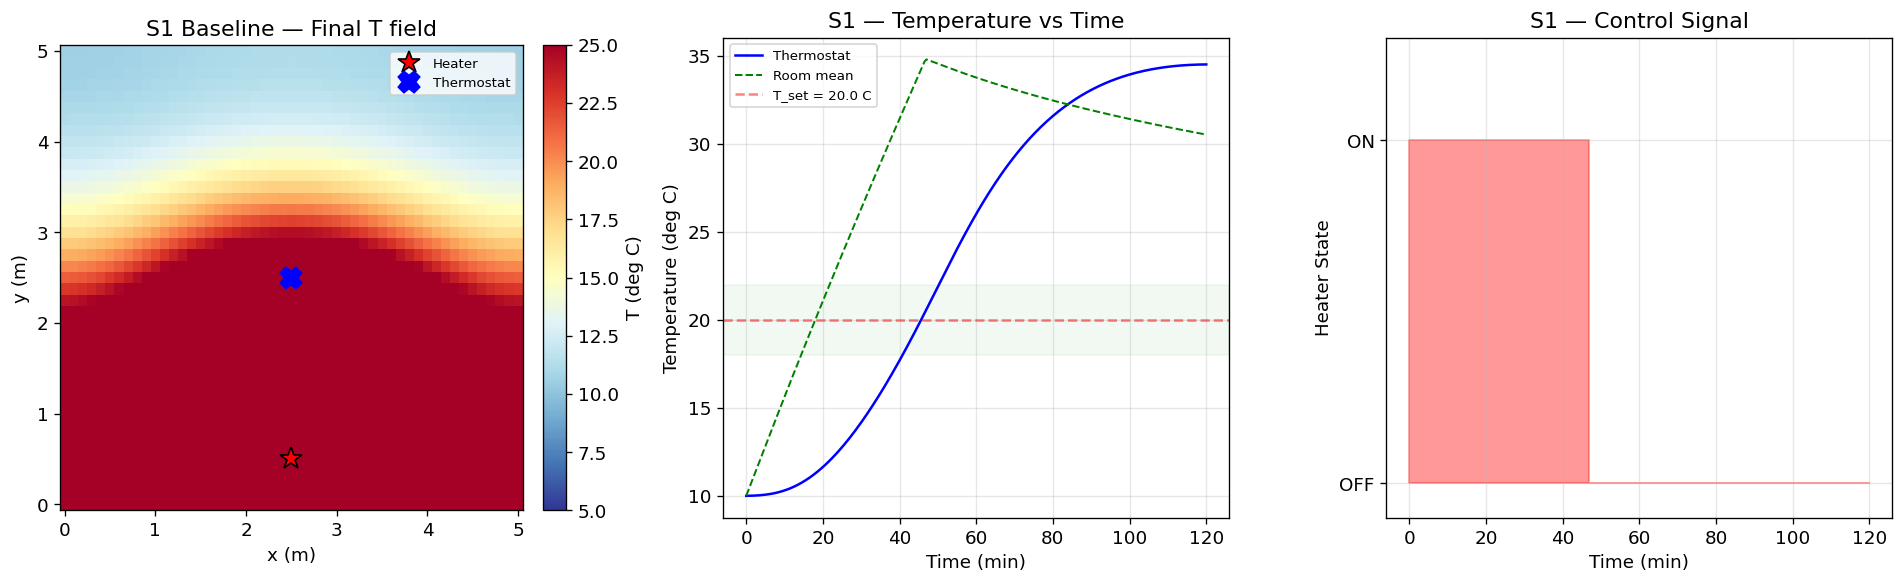

终态恒温器读数: 34.5 C
终态房间均温:   30.5 C
空间不均匀度 (std): 17.7 C


In [4]:
cfg_s1 = make_baseline()
m1, t1, Tf1, Tt1, u1 = run_scenario(cfg_s1)
Tmean1 = np.mean(Tf1, axis=(0, 1))  # 房间空间平均温度随时间变化

fig = plt.figure(figsize=(16, 5))

# 左图：终态温度场
ax1 = fig.add_subplot(1, 3, 1)
plot_field(ax1, m1, Tf1[:,:,-1], cfg_s1, title='S1 Baseline — Final T field')

# 中图：温度时间曲线
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(t1, Tt1, 'b-', lw=1.5, label='Thermostat')
ax2.plot(t1, Tmean1, 'g--', lw=1.2, label='Room mean')
ax2.axhline(T_SET, color='r', ls='--', alpha=0.5, label=f'T_set = {T_SET} C')
ax2.axhspan(T_SET - 2, T_SET + 2, color='green', alpha=0.05)
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Temperature (deg C)')
ax2.set_title('S1 — Temperature vs Time')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 右图：控制信号
ax3 = fig.add_subplot(1, 3, 3)
ax3.fill_between(t1, u1 / U_MAX, step='mid', alpha=0.4, color='red')
ax3.set_xlabel('Time (min)')
ax3.set_ylabel('Heater State')
ax3.set_title('S1 — Control Signal')
ax3.set_yticks([0, 1])
ax3.set_yticklabels(['OFF', 'ON'])
ax3.set_ylim(-0.1, 1.3)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"终态恒温器读数: {Tt1[-1]:.1f} C")
print(f"终态房间均温:   {Tmean1[-1]:.1f} C")
print(f"空间不均匀度 (std): {np.std(Tf1[:,:,-1]):.1f} C")

**观察**：加热器在南墙附近产生一个高温区（>25°C），热量缓慢向房间中心扩散。恒温器位于 2m 外，升温明显滞后于加热器附近。空间温差很大。

---
## 5. S2 — 南墙加窗户

与 S1 相同的房间，但南墙中间 2m 是**单层玻璃窗**：

$$h_{\text{south}}(x) = \begin{cases} 0.5 & x < 1.5 \text{ 或 } x > 3.5 \\ 2.5 & 1.5 \le x \le 3.5 \end{cases}$$

窗户 $h = 2.5$ 是普通墙面的 **5 倍** —— 热量通过窗户流失更快。

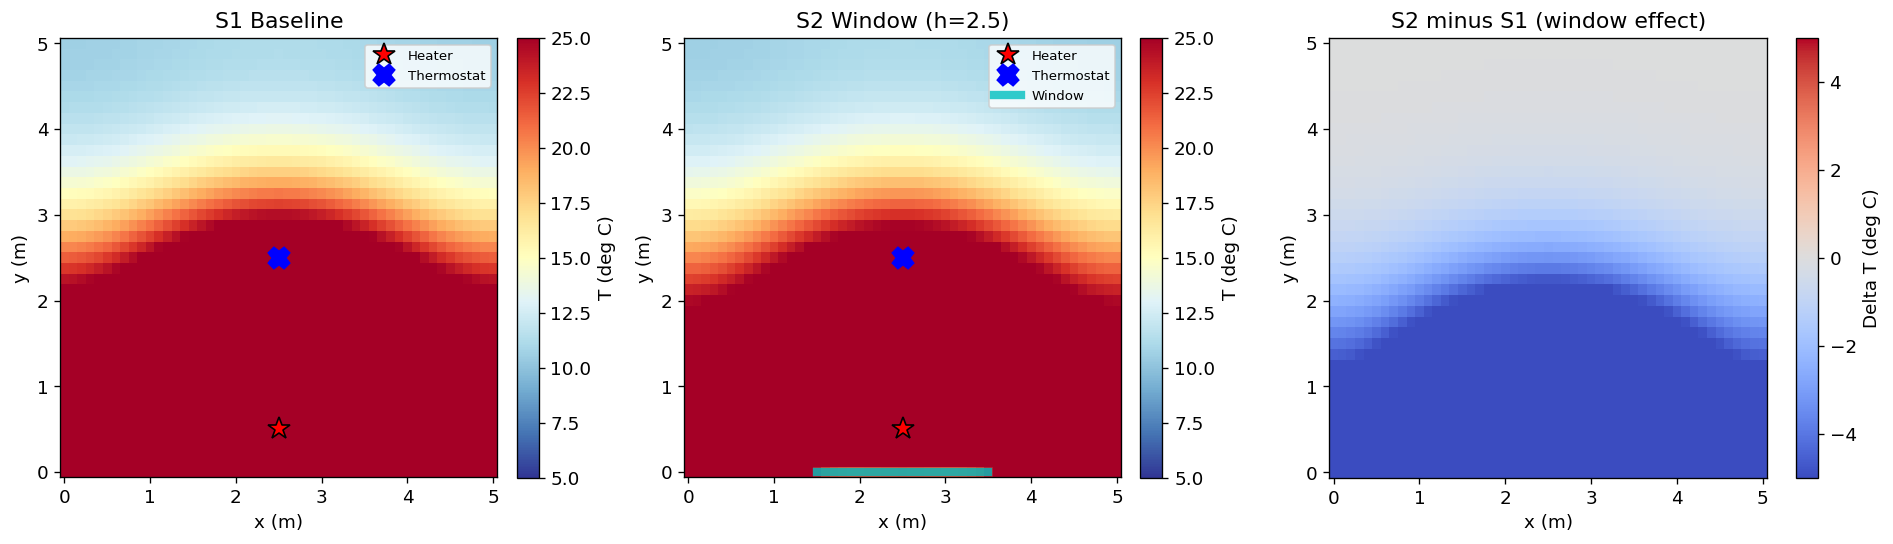

S1 均温: 30.5 C, 不均匀度: 17.7 C
S2 均温: 24.7 C, 不均匀度: 11.2 C
窗户区域 (y=0) 平均降温: 38.2 C


In [5]:
cfg_s2 = make_window()
m2, t2, Tf2, Tt2, u2 = run_scenario(cfg_s2)

# 三栏：S1 / S2 / 差值图
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5),
                         gridspec_kw={'width_ratios': [1, 1, 1.2]})

plot_field(axes[0], m1, Tf1[:,:,-1], cfg_s1, title='S1 Baseline')
plot_field(axes[1], m2, Tf2[:,:,-1], cfg_s2, title='S2 Window (h=2.5)')

# 差值图：窗户带来的温度变化
diff = Tf2[:,:,-1] - Tf1[:,:,-1]
im = axes[2].pcolormesh(m1.x, m1.y, diff.T, shading='auto', cmap='coolwarm',
                        vmin=-5, vmax=5)
plt.colorbar(im, ax=axes[2], label='Delta T (deg C)')
axes[2].set_title('S2 minus S1 (window effect)')
axes[2].set_xlabel('x (m)')
axes[2].set_ylabel('y (m)')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"S1 均温: {Tf1[:,:,-1].mean():.1f} C, 不均匀度: {np.std(Tf1[:,:,-1]):.1f} C")
print(f"S2 均温: {Tf2[:,:,-1].mean():.1f} C, 不均匀度: {np.std(Tf2[:,:,-1]):.1f} C")
print(f"窗户区域 (y=0) 平均降温: {(Tf1[20:30,0,-1] - Tf2[20:30,0,-1]).mean():.1f} C")

**观察**：窗户在南墙中央形成了一个**冷通道**。差值图（右）清楚显示窗户区域温度降低数度，整个房间也因为额外热损而略微降温。

---
## 6. S3 — 窗户参数对比

三种窗户配置，对比窗户大小和材质的影响：

| 配置 | 窗宽 | $h_{\text{window}}$ | 物理含义 |
|------|------|---------------------|----------|
| 小窗 | 1 m | 2.5 | 普通小窗 |
| 大窗 | 3 m | 2.5 | 落地窗 / 全景窗 |
| 双层窗 | 2 m | 1.0 | 节能双层中空玻璃 |

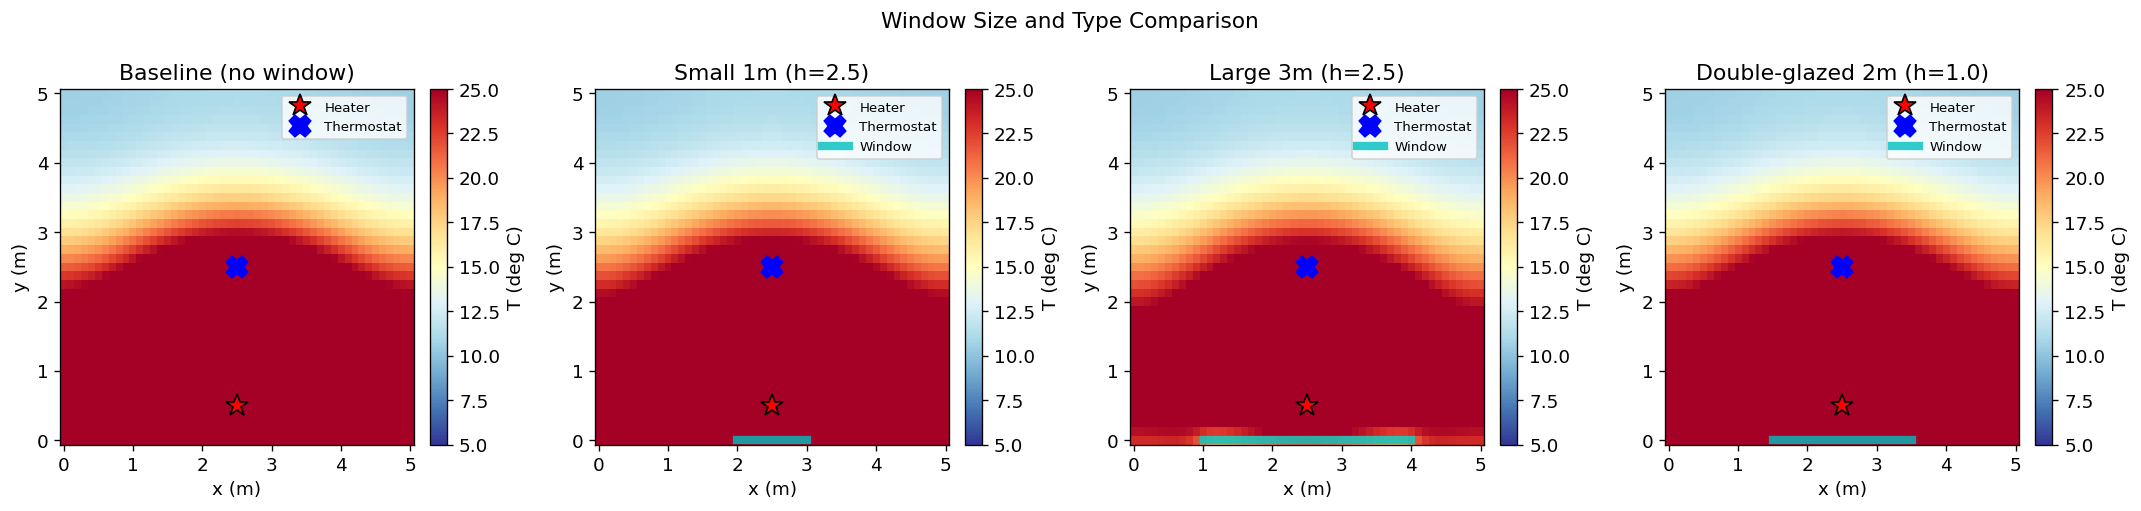

Config                         Mean T        Std   South wall
--------------------------------------------------------------
Baseline (no window)            30.5C     17.7C       46.4C
Small 1m (h=2.5)                26.6C     13.0C       32.2C
Large 3m (h=2.5)                23.7C     10.5C       21.2C
Double-glazed 2m (h=1.0)        28.1C     14.7C       37.0C


In [6]:
cfgs_s3 = make_window_compare()
results_s3 = []
for cfg in cfgs_s3:
    m, t, Tf, Tt, u = run_scenario(cfg)
    results_s3.append((cfg, m, t, Tf, Tt, u))

# 四栏并排：基线 + 3 种窗
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
all_win = [(cfg_s1, m1, Tf1)] + [(r[0], r[1], r[3]) for r in results_s3]
titles = ['Baseline (no window)', 'Small 1m (h=2.5)', 'Large 3m (h=2.5)', 'Double-glazed 2m (h=1.0)']

for ax, (cfg, model, Tf), title in zip(axes, all_win, titles):
    plot_field(ax, model, Tf[:,:,-1], cfg, title=title)

fig.suptitle('Window Size and Type Comparison', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# 数值对比
print(f"{'Config':<28} {'Mean T':>8} {'Std':>10} {'South wall':>12}")
print('-' * 62)
for (cfg, m, Tf), title in zip(all_win, titles):
    print(f"{title:<28} {Tf[:,:,-1].mean():>7.1f}C {np.std(Tf[:,:,-1]):>8.1f}C {Tf[:,0,-1].mean():>10.1f}C")

**关键发现**：
- 窗户越大，南墙温度越低，整体热损越大
- 双层中空玻璃（$h=1.0$）在同等窗宽下显著减少热损 —— 这是节能建筑的核心策略

---
## 7. S4 — 开门通风（时变边界条件）

**西墙**（$x=0$）上有一扇门（$y \in [1.0, 2.5]$，宽 1.5m）：
- $t < 30$ min：门关闭，$h = 0$（保温）
- $30 \leq t \leq 40$ min：门打开，$h = 10$（强对流，近似直接暴露在室外）
- $t > 40$ min：门关闭，$h = 0$

实现方式：通过 **callback 函数**在每个时间步更新 $h_{\text{west}}$ 数组。

In [ ]:
cfg_s4 = make_door_opening(t_open=30.0, t_close=40.0)
m4, t4, Tf4, Tt4, u4 = run_scenario(cfg_s4)
Tmean4 = np.mean(Tf4, axis=(0, 1))

# 五个关键时刻的温度场快照
snap_times = [20, 30, 35, 40, 60]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, ts in zip(axes, snap_times):
    idx = np.argmin(np.abs(t4 - ts))
    im = ax.pcolormesh(m4.x, m4.y, Tf4[:,:,idx].T,
                       shading='auto', cmap='RdYlBu_r', vmin=5, vmax=25)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    status = 'OPEN' if 30 <= ts <= 40 else 'closed'
    ax.set_title(f't = {ts} min (door {status})', fontsize=10)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_aspect('equal')
    # 用品红色标记门的位置
    color = 'magenta' if 30 <= ts <= 40 else 'gray'
    ax.plot([0, 0], [1.0, 2.5], color=color, lw=4, alpha=0.8)

fig.suptitle('S4 Door Opening — Temperature Snapshots', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# S1 vs S4 温度对比
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True,
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(t1, Tt1, 'b-', lw=1.5, label='S1 Baseline (thermostat)')
ax1.plot(t4, Tt4, 'r-', lw=1.5, label='S4 Door (thermostat)')
ax1.plot(t1, Tmean1, 'b--', lw=1, alpha=0.5, label='S1 Baseline (room mean)')
ax1.plot(t4, Tmean4, 'r--', lw=1, alpha=0.5, label='S4 Door (room mean)')
ax1.axhline(T_SET, color='k', ls=':', alpha=0.3)
ax1.axvspan(30, 40, color='orange', alpha=0.15, label='Door open window')
ax1.set_ylabel('Temperature (deg C)')
ax1.legend(fontsize=9)
ax1.set_title('S4 vs S1 — Impact of Door Opening')
ax1.grid(True, alpha=0.3)

ax2.fill_between(t4, u4 / U_MAX, step='mid', alpha=0.35, color='red')
ax2.axvspan(30, 40, color='orange', alpha=0.15)
ax2.set_ylabel('Heater')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['OFF', 'ON'])
ax2.set_xlabel('Time (min)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 量化开门影响
idx_29 = np.argmin(np.abs(t4 - 29))
idx_40 = np.argmin(np.abs(t4 - 40))
print(f"开门前 (t=29min) 房间均温: {Tmean4[idx_29]:.1f} C")
print(f"关门时 (t=40min) 房间均温: {Tmean4[idx_40]:.1f} C")
print(f"开门导致的温降:           {Tmean4[idx_29] - Tmean4[idx_40]:.1f} C")

**观察**：开门 10 分钟在西墙门口产生明显的冷空气入侵。房间均温骤降，加热器需要额外时间和能量来恢复温度。

---
## 8. S5 — 长窄房间（长宽比 3:1）

$7.5 \times 2.5$ m 房间（面积 18.75 m²），长宽比 3:1。加热器在中心位置。

**物理直觉**：热扩散的特征长度 $\ell = \sqrt{\alpha t}$。在 $t=60$ min 时 $\ell \approx 0.77$ m。房间长 7.5 m，远端距加热器 ~3.75 m ≈ **5 个特征长度**，因此远端一定很冷。

In [ ]:
cfg_s5 = make_narrow_room()
m5, t5, Tf5, Tt5, u5 = run_scenario(cfg_s5)

# 上下对比：方形 vs 长窄
fig, axes = plt.subplots(2, 1, figsize=(14, 7))

# S1 方形
im1 = axes[0].pcolormesh(m1.x, m1.y, Tf1[:,:,-1].T,
                         shading='auto', cmap='RdYlBu_r', vmin=5, vmax=25)
plt.colorbar(im1, ax=axes[0], label='T (deg C)', fraction=0.02, pad=0.02)
axes[0].plot(*cfg_s1['heater_pos'], 'r*', ms=12, mec='k')
axes[0].plot(*cfg_s1['thermostat_pos'], 'bX', ms=10, mew=2)
axes[0].set_title('S1 Baseline (5 x 5 m)')
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')
axes[0].set_aspect('equal')

# S5 长窄
im5 = axes[1].pcolormesh(m5.x, m5.y, Tf5[:,:,-1].T,
                         shading='auto', cmap='RdYlBu_r', vmin=5, vmax=25)
plt.colorbar(im5, ax=axes[1], label='T (deg C)', fraction=0.02, pad=0.02)
axes[1].plot(*cfg_s5['heater_pos'], 'r*', ms=12, mec='k')
axes[1].plot(*cfg_s5['thermostat_pos'], 'bX', ms=10, mew=2)
axes[1].set_title('S5 Narrow (7.5 x 2.5 m)')
axes[1].set_xlabel('x (m)')
axes[1].set_ylabel('y (m)')
axes[1].set_aspect('equal')

fig.suptitle('Room Shape: Square vs Narrow', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# 沿长轴的温度剖面
mid_y = cfg_s5['ny'] // 2
T_profile = Tf5[:, mid_y, -1]
print(f"沿中线 (y={m5.y[mid_y]:.1f}m) 的温度:")
print(f"  左端 (x=0):    {Tf5[0, mid_y, -1]:.1f} C")
print(f"  中心 (x=3.75): {Tf5[len(m5.x)//2, mid_y, -1]:.1f} C")
print(f"  右端 (x=7.5):  {Tf5[-1, mid_y, -1]:.1f} C")
print(f"  端到端温差:    {T_profile.max() - T_profile.min():.1f} C")

**关键发现**：长窄房间的温度不均匀性极大。加热器只能温暖附近的小区域，远端仍然接近室外温度。这说明**房间几何形状从根本上限制了单个加热器的温度均匀性**。

---
## 9. S6 — L 形房间（域 mask）

在 $5 \times 5$ 正方形网格上去掉右上角 $[2.5,5] \times [2.5,5]$，得到 L 形域：

$$\Omega_L = \big([0,5] \times [0,2.5]\big) \cup \big([0,2.5] \times [2.5,5]\big)$$

实现方式：布尔 **domain mask** 数组，被排除的网格点 $dT/dt = 0$。

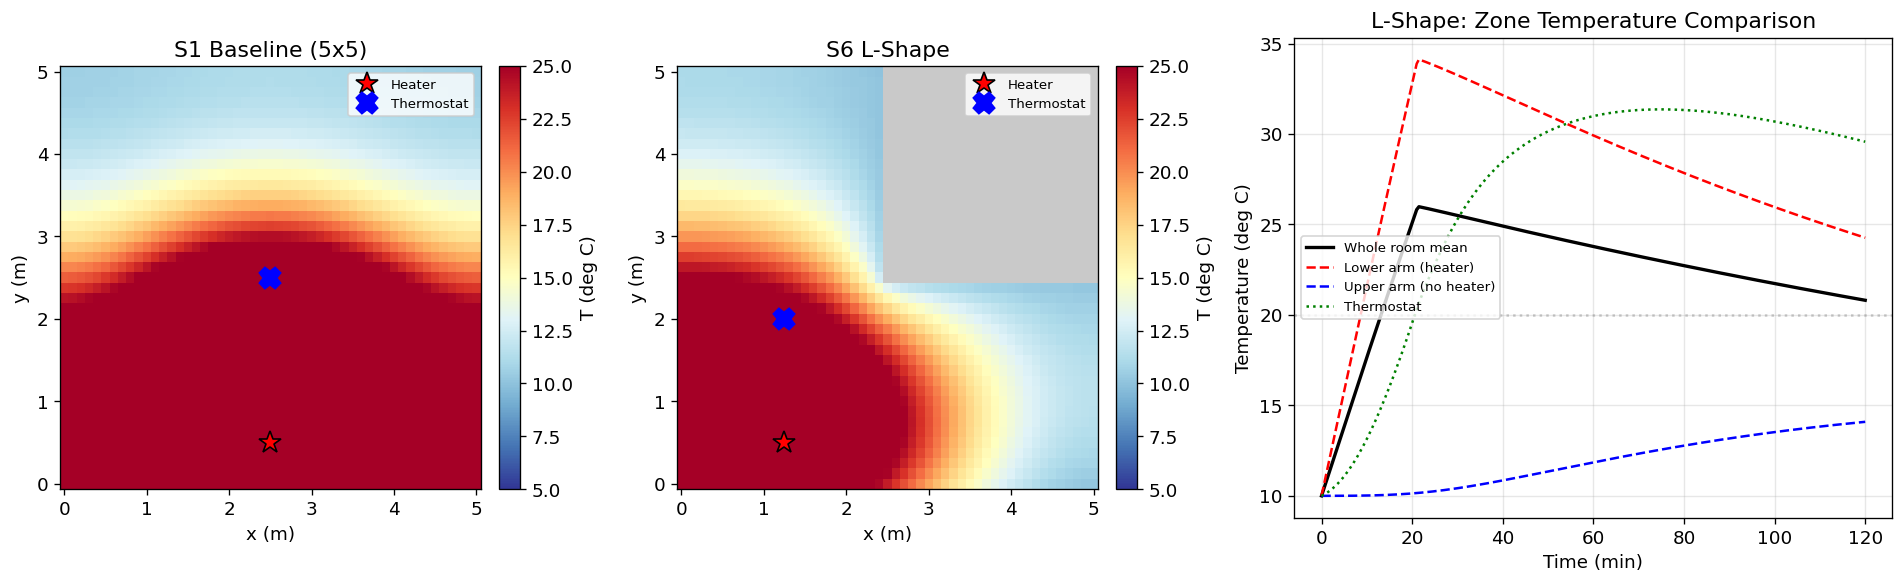

终态下臂均温: 24.3 C
终态上臂均温: 14.1 C
两臂温差:     10.2 C


In [7]:
cfg_s6 = make_L_shape()
m6, t6, Tf6, Tt6, u6 = run_scenario(cfg_s6)

mask = cfg_s6['domain_mask']
# 只对有效区域求均温
T_active_mean = np.array([Tf6[:,:,i][mask].mean() for i in range(len(t6))])

fig, axes = plt.subplots(1, 3, figsize=(16, 5),
                         gridspec_kw={'width_ratios': [1, 1, 1.3]})

plot_field(axes[0], m1, Tf1[:,:,-1], cfg_s1, title='S1 Baseline (5x5)')
plot_field(axes[1], m6, Tf6[:,:,-1], cfg_s6, title='S6 L-Shape')

# L 形房间分区温度分析
x6, y6 = m6.x, m6.y
X6, Y6 = np.meshgrid(x6, y6, indexing='ij')

lower_arm = mask & (Y6 < 2.5)   # 下臂（有加热器）
upper_arm = mask & (Y6 >= 2.5)  # 上臂（无加热器）

T_lower = np.array([Tf6[:,:,i][lower_arm].mean() for i in range(len(t6))])
T_upper = np.array([Tf6[:,:,i][upper_arm].mean() for i in range(len(t6))])

axes[2].plot(t6, T_active_mean, 'k-', lw=2, label='Whole room mean')
axes[2].plot(t6, T_lower, 'r--', lw=1.5, label='Lower arm (heater)')
axes[2].plot(t6, T_upper, 'b--', lw=1.5, label='Upper arm (no heater)')
axes[2].plot(t6, Tt6, 'g:', lw=1.5, label='Thermostat')
axes[2].axhline(T_SET, color='gray', ls=':', alpha=0.4)
axes[2].set_xlabel('Time (min)')
axes[2].set_ylabel('Temperature (deg C)')
axes[2].set_title('L-Shape: Zone Temperature Comparison')
axes[2].legend(fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"终态下臂均温: {T_lower[-1]:.1f} C")
print(f"终态上臂均温: {T_upper[-1]:.1f} C")
print(f"两臂温差:     {T_lower[-1] - T_upper[-1]:.1f} C")

**关键发现**：L 形房间的两个臂之间存在巨大温差。上臂没有加热器，热量必须绕过拐角扩散，形成了一个**热死角**。

---
## 10. 全场景综合对比

In [ ]:
# 收集所有场景结果
all_scenarios = [
    ('S1 Baseline', cfg_s1, m1, Tf1, Tt1, u1, t1, None),
    ('S2 Window',   cfg_s2, m2, Tf2, Tt2, u2, t2, None),
    ('S4 Door',     cfg_s4, m4, Tf4, Tt4, u4, t4, None),
    ('S5 Narrow',   cfg_s5, m5, Tf5, Tt5, u5, t5, None),
    ('S6 L-Shape',  cfg_s6, m6, Tf6, Tt6, u6, t6, mask),
]

# 2x3 面板：所有场景终态温度场
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes_flat = axes.ravel()

for i, (name, cfg, model, Tf, Tt, u, t, msk) in enumerate(all_scenarios):
    plot_field(axes_flat[i], model, Tf[:,:,-1], cfg, title=name)

axes_flat[-1].set_visible(False)  # 隐藏第6个空白子图
fig.suptitle('All Scenarios — Final Temperature Fields (t = 120 min)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# 柱状图对比
names = [s[0] for s in all_scenarios]
nonunif = []
mean_temps = []
for name, cfg, model, Tf, Tt, u, t, msk in all_scenarios:
    T_final = Tf[:,:,-1]
    if msk is not None:
        nonunif.append(T_final[msk].std())
        mean_temps.append(T_final[msk].mean())
    else:
        nonunif.append(T_final.std())
        mean_temps.append(T_final.mean())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']

# 左图：均温
bars1 = ax1.bar(names, mean_temps, color=colors)
ax1.axhline(T_SET, color='red', ls='--', alpha=0.5, label=f'T_set = {T_SET} C')
ax1.set_ylabel('Final Mean Temperature (deg C)')
ax1.set_title('How close to the setpoint?')
ax1.tick_params(axis='x', rotation=20)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
for bar, v in zip(bars1, mean_temps):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{v:.1f}', ha='center', fontsize=9)

# 右图：不均匀度
bars2 = ax2.bar(names, nonunif, color=colors)
ax2.set_ylabel('Spatial Non-uniformity std(T) (deg C)')
ax2.set_title('How uniform is the temperature?')
ax2.tick_params(axis='x', rotation=20)
ax2.grid(True, alpha=0.3, axis='y')
for bar, v in zip(bars2, nonunif):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{v:.1f}', ha='center', fontsize=9)

fig.suptitle('Cross-Scenario Performance Comparison', fontsize=13)
plt.tight_layout()
plt.show()

---
## 11. 总结

### 核心发现

通过**同一个 PDE 求解器 + 分段式 Robin 边界条件**，我们展示了不同物理场景对温度分布的影响：

| 因素 | 对温度分布的影响 |
|------|------------------|
| **窗户** (S2, S3) | 在外墙产生冷区；窗越大热损越多；双层窗显著降低热损 |
| **开门** (S4) | 瞬态冷空气入侵；关门后温度恢复，但需额外能耗 |
| **长窄房间** (S5) | 极端温度不均匀；远离加热器的端部始终偏冷 |
| **L 形房间** (S6) | 无加热器的臂产生热死角；热量难以绕过拐角扩散 |

### 建模方法的特点

- **不需要新方程** —— 所有场景只改 $h$ 参数数组
- **时变 BC**（开门）通过 callback 函数实现
- **不规则域**（L 形）通过布尔 mask 实现
- 所有改动与基线求解器**完全向后兼容**

### 对恒温器位置的启示

实验表明**恒温器读数 ≠ 房间实际温度**。在所有场景中，恒温器读数与空间均温差异显著：
- 恒温器靠近加热器 → 读数偏高 → 加热器过早关闭 → 远端偏冷
- 恒温器远离加热器 → 读数偏低 → 加热器过度运行 → 加热器附近过热
- 不规则形状的房间中，恒温器位置的选择更加关键

---
## 附录：代码架构

### `pde_2d_model.py` 的核心改动

原始求解器对四面墙使用同一个标量 `h_wall`。我们将其扩展为**每面墙独立的 $h$ 数组**：

```python
# 改动前：所有墙面统一 h
self.h_wall = h_wall  # 标量

# 改动后：四面墙各自一个数组
self.h_south = wall_h.get('south', np.full(nx, h_wall))  # 长度 nx
self.h_north = wall_h.get('north', np.full(nx, h_wall))
self.h_west  = wall_h.get('west',  np.full(ny, h_wall))  # 长度 ny
self.h_east  = wall_h.get('east',  np.full(ny, h_wall))
```

在 ghost-point 离散化中：
```python
# 改动前（标量乘法）：
... - 2*dy*self.h_wall*(T[1:-1, 0] - self.T_a) ...

# 改动后（数组逐元素乘法）：
... - 2*dy*self.h_south[1:-1]*(T[1:-1, 0] - self.T_a) ...
```

NumPy 的逐元素乘法自动让每个网格点用各自的 $h$ 值。

**总改动量**：`rhs()` 中 ~12 处 `h_wall` → 对应方向数组切片 + `__init__()` 中 3 个新参数。